In [5]:
import response_utils
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use a LaTeX-compatible serif font
    "font.serif": ["Computer Modern Roman"],  # Or another LaTeX font
})

%load_ext autoreload
%autoreload 2

In [76]:
# Grid parameters
dt = 1
Nt = 250 # Number of years
t = np.arange(0,dt*Nt,dt)
Nt = len(t)

# ODE parameters
rho_w = 1e3
c_w = 4e3
h = np.array([10.0, 150.0, 1500.0])
C = rho_w*c_w*h/3.154e7 # convert from seconds to years
lam = np.array([-0.86, -2.0, -0.67])
T0 = 0 # K
F0 = 1

# Forcing parameters
## 2xCO2 and 4xCO2 (constant forcing)
F_2xCO2 = response_utils.F_const(t, 3.7)
F_4xCO2 = response_utils.F_const(t, 7.4)

## RCP70
F_final = 7 # (W m^-2)
ts = 50
a_exp = F_final/np.exp(250*dt/ts)
F_exp = response_utils.F_exp(t, a_exp, ts)

## Overshoot
a_over = 4
b_over = 200
c_over = 42.7
F_over = response_utils.F_over(t, a_over, b_over, c_over)

## Impulse forcing
F0 = 1
F_pulse = response_utils.F_del(t, F0)
F_del = {'2xCO2':F_pulse,
         '4xCO2':F_pulse,
         'RCP70':F_pulse,
         'Overshoot':F_pulse}

## Compile all for diagnosis
F_all = {'2xCO2':F_2xCO2,
         '4xCO2':F_4xCO2,
         'RCP70':F_exp,
         'Overshoot':F_over}

# Plotting parameters
experiments = ['2xCO2','4xCO2','RCP70','Overshoot']
regions = ['Atmosphere', 'Shallow Ocean', 'Deep Ocean']
colors = ['g','r','b']

# Stochastic parameters
K1 = 0.1
K2 = 0.75
alpha = 4
N_ensemble = 50

# Generated perturbed ensemble
F_all_ensemble = gen_F_ensemble_exponential_noise(F_all, t, K1, K2, alpha, N_ensemble, experiments)

T_analytic, g_analytic, a_analytic = response_utils.timestep_uncoup(t, experiments, regions, F_all, lam, C, dt)
T_ensemble, g_ensemble, a_ensemble = response_utils.timestep_uncoup(t, experiments, regions, F_all_ensemble, lam, C, dt, N_ensemble)


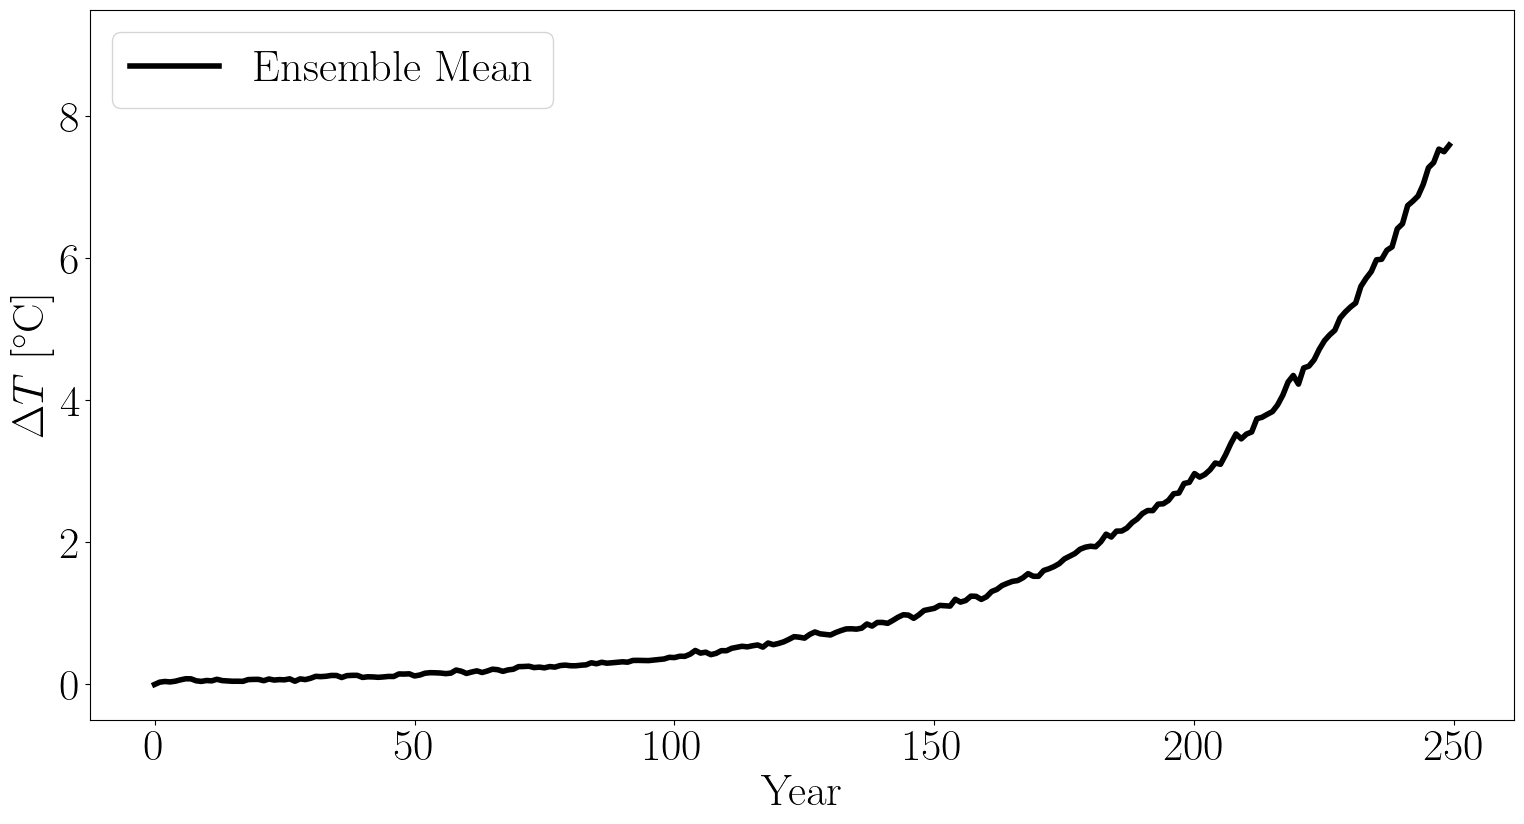

In [97]:
#plt.rcParams.update({'font.size': 32})
T_temp = T_ensemble['RCP70']['Atmosphere']
T_mean = np.mean(T_temp, axis=0)
T_std = np.std(T_temp, axis=0)

fig, ax = plt.subplots(figsize=(16,9))
ax.plot(T_mean, lw=4, c='k', label='Ensemble Mean')

#ax.plot(T_temp[2,:], lw=4, label='Ensemble Member 1')
#ax.plot(T_temp[1,:], lw=4, label='Ensemble Member 2')

#ax.fill_between(t, T_mean - T_std, T_mean + T_std, color='gray', alpha=0.5, label='Ensemble Spread (±1 std)')
#ax.fill_between(t, T_mean - 2*T_std, T_mean + 2*T_std, color='gray', alpha=0.2, label='Ensemble Spread (±2 std)')

ax.set_ylabel(r'$\Delta T$ [$^\circ$C]')
ax.set_xlabel('Year')
ax.set_ylim([-0.5,9.5])
ax.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('EnsembleMeanLegend.png', dpi=500)

In [53]:
def gen_F_ensemble_exponential_noise(F, t, K1, K2, alpha, N_ensemble, experiments):
    F_ensemble = {}
    
    # Create an exponentially varying noise strength from K1 to K2
    K_varying = K1 * np.exp(alpha * (np.arange(len(t)) / len(t))) 
    K_varying = K_varying / K_varying[-1] * (K2 - K1) + K1  # Normalize to range from K1 to K2
    
    # Generate random noise
    xi = np.random.normal(0, 1, (N_ensemble, len(t)))
    
    for exp in experiments:
        # Scale the noise with the exponentially varying K values
        F_ensemble[exp] = xi * K_varying + F[exp]

    return F_ensemble

In [13]:
from math import gcd

def extended_gcd(a, b):
    """Performs the Extended Euclidean Algorithm.
    Returns gcd(a, b), x, y where ax + by = gcd(a, b).
    """
    if b == 0:
        return a, 1, 0
    g, x1, y1 = extended_gcd(b, a % b)
    x = y1
    y = x1 - (a // b) * y1
    return g, x, y

def solve_diophantine(a, b, c):
    """Solves the Diophantine equation a*x + b*y = c.
    Returns a particular solution (x, y) if it exists, otherwise None.
    """
    g, x0, y0 = extended_gcd(a, b)
    if c % g != 0:
        # No solution exists
        return None

    # Scale the solution to satisfy a*x + b*y = c
    scale = c // g
    x = x0 * scale
    y = y0 * scale
    return x, y

# Example usage
a = 15
b = 10
c = 35

tau_1 = 2914.2582939639506
tau_2 = 3232.0113349112908
T_1 = 5828.516683695568
T_2 = 6464.022790934933
delta_tau = tau_2 - tau_1

a = T_1
b = T_2
c = delta_tau

solution = solve_diophantine(a, b, c)
if solution:
    x, y = solution
    print(f"A solution to {a}x + {b}y = {c} is x = {x}, y = {y}")
else:
    print(f"No solution exists for {a}x + {b}y = {c}")

print(f"Collision time = {a*x - b*y}")

A solution to 5828.516683695568x + 6464.022790934933y = 317.7530409473402 is x = 1.0035182510928593e+30, y = -9.048580207808558e+29
Collision time = 1.1698045737775456e+34


In [51]:
from pulp import *

# Given constants
tau_1 = 2914.2582939639506
tau_2 = 3232.0113349112908
T_1 = 5828.516683695568
T_2 = 6464.022790934933
delta_tau = tau_2 - tau_1
eps = 0.01

# Define the problem
prob_eps = LpProblem("Minimize_S_w_eps", LpMinimize)

# Decision variables
n1 = LpVariable("n1", lowBound=1, cat="Integer")
n2 = LpVariable("n2", lowBound=1, cat="Integer")
S = LpVariable("S", lowBound=0)

# Objective function
prob_eps += S

# Constraints
prob_eps += n1 * T_1 - n2 * T_2 <= delta_tau + eps, "Inequality_Constraint_1"
prob_eps += n1 * T_1 - n2 * T_2 >= delta_tau - eps, "Inequality_Constraint_2"
prob_eps += S >= tau_1 + n1 * T_1 + tau_2 + n2 * T_2, "Objective_Definition"

# Solve the problem
prob_eps.solve()


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/chriswomack/anaconda3/envs/research/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/5v/9rw_h5d56d57jgsmbk2dfb980000gn/T/17f6244ab3294b6b98bfa30fda94c836-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/5v/9rw_h5d56d57jgsmbk2dfb980000gn/T/17f6244ab3294b6b98bfa30fda94c836-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 8 COLUMNS
At line 21 RHS
At line 25 BOUNDS
At line 28 ENDATA
Problem MODEL has 3 rows, 3 columns and 7 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 19392.1 - 0.00 seconds
Cgl0003I 0 fixed, 5 tightened bounds, 0 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 4 tightened bounds, 0 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 4 tightened bounds, 0 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 4 ti

1

In [52]:
# Output the results
for v in prob_eps.variables():
  print(v.name, "=", v.varValue)
print("Minimum Time to Collision w/ Eps = ", value(prob_eps.objective))

S = 1027281900.0
n1 = 88125.0
n2 = 79461.0
Minimum Time to Collision w/ Eps =  1027281900.0
